# IE Sustainability Datathon February 2025

Group name : CTR + ALT + DEFEAT

Group members : Joy Zhong, Joel James Alarde, Maria do Carmo Brito e Abreu, Emiliano Puertas Ajuria, Uxia Lojo Miranda, Sebastian Zambrano

In [103]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from scipy.stats import randint as sp_randint, uniform
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


**PROBLEM OVERVIEW : Integrating Renewable Energy**

The task revolves around managing solar energy generation and consumption via a **theoretical battery**. The goal is to balance the maximum possible solar energy generated and energy consumed by the battery. By integrating solar energy in Repsol's industrial factory through the battery, it can **lower dependence on the electricy grid** and **reduce its overall CO2 emissions**.

---

**KEY CONCEPTS**

**1. Solar Generation & Consumption**
   - **Generation** : amount of photovoltaic energy generated by the industrial factory measured in kilowatt-hour (kWh)
      - based on weather data and installation characteristics (location)
   - **Consumption** : amount of energy actually utilized by industrial demand in kWh
   - If **generation** is higher than **consumption**, there’s an **energy excess**, leading to lost or wasted energy
   - If **generation** is lower than **consumption**, there’s an **energy shortage**, leading to increased reliance on non-renewable energy in the electricity grid

**2. Theoretical Battery**
   - **Charge** : maximum generated solar energy the battery can store ; it is set at 100 kilowatts (kW)
      - based on excess solar generation
   - **Discharge** : maximum stored solar energy the battery can release ; it is set at 100 kW
      - based on consumption of the industrial factory
   - Only **one charge-discharge cycle** is allowed per day
   - Disconnection from the electricity grid ensures energy charged by the battery can only by discharged to the industrial factory

**3. Environmental Impact**
   - **CO2 equivalent emissions (CO2eq)** : quantified amount of the total effect of all greenhouse gases in terms of amount of CO2 that produces the same warming effect
   - **Carbon intensity** : amount of CO2eq produced per unit of energy generated measured in grams CO2 per kilowatt-hour (gCO2 / kWh)
      - generally, coal has a high carbon intensity while solar has a near zero carbon intensity

---

**OBJECTIVES**

The objectives are split into **three main parts** with the following expected outputs :

**1. Calculation of solar energy potentials**
   - potential solar generation based on a model with performance metric of Mean Absolute Error (MAE) > lower is better
   - undertilization of solar energy computed as :
      - *potential solar generation - consumption of industrial factory*

**2. Optimization of battery usage**
   - self-consumption ratio (Ra) computed as :
      - *(solar energy used directly + solar energy stored & subsequently used) / potential solar generation * 100* > higher is better
   - methodology of battery mechanics (usage of generation and consumption to decide when and how much to charge and discharge)
   - achievement of efficient discharge (timing of discharge should match with the highest carbon intensity being consumed from the electricity grid)

**3. Analysis of environmental impact**
   - optimized CO2eq computed as :
      - *C02 baseline emissions (w/o battery impact) - CO2 optimized emissions (w/ battery impact)* > higher is better
   - CO2 baseline emissions computed as :
      - *sum of (energy consumption in each hour x carbon intensity in each hour)*
   - CO2 optimized emissions computed as :
      - *sum of (optimized energy consumption in each hour x carbon intensity in each hour)*
   - methodology of carbon intensities (how optimization was achieved)

---

**DATASET VARIABLES**

**1. Generacion_fotovoltaica - covers July 2023 to August 2024**
   - **Fecha** : date and time of photovoltaic generation in Madrid time zone
   - **Total kWh Energia** : total photovoltaic generation during the time period

**2. Consumo_fotovoltaica - covers September 2024**
   - **Fecha** : date and time of photovoltaic consumption in Madrid time zone
   - **Total kWh Energia** : total photovoltaic consumption during the time period

**3. Consumo & Consumo_sept - covers July 2023 to September 2024**
   - **Fecha** : date and time of energy consumption in Madrid time zone
   - **Total kWh Energia** : total energy consumption from the electricity grid by the industrial factory during the time period

**4. Meteorologia**
   - **Forecast_Timestamp** : forecast time & date in UTC
   - **Latitude** : latitude of forecast location
   - **Longitude** : longitude of forecast location

   *Factors in the atmosphere*
   - **pwatatmosphereSingleLayer_0** : total precipitable water in the atmosphere in kg / m²
   - **tozneatmosphereSingleLayer_0** : total amount of ozone in the atmosphere in DU
   - **tccatmosphere_0** : total cloud cover in the atmosphere in %

   *Factors on the surface*
   - **SUNSDsurface_0** : sunshine duration on the surface in s
   - **dlwrfsurface_0** : downward longwave radiation on the surface in W / m²
   - **dswrfsurface_0** : downward shortwave radiation on the surface in W / m²
   - **gustsurface_0** : maximum wind gusts on the surface in m / s
   - **tpsurface_0** : total accumulated precipitation on the surface in mm
   - **tsurface_0** : surface temperature in degrees K
   - **msletmeanSea_0** : sea level pressure in Pa
   - **spsurface_0** : surface pressure in Pa

   *Factors 2m above the ground*
   - **2rheightAboveGround_2** : relative humidity at 2m above the ground in %
   - **2shheightAboveGround_2** : specific humidity at 2m above the ground in kg / kg
   - **2theightAboveGround_2** : air temperature at 2m above the ground in degrees K
   - **aptmpheightAboveGround_2** : apparent temperature at 2m above the ground in degrees K
   - **tmaxheightAboveGround_2** : maximum air temperature at 2m above the ground in degrees K
   - **tminheightAboveGround_2** : minimum air temperature at 2m above the ground in degrees K

   *Factors 10m above the ground*
   - **10uheightAboveGround_10** : U component of the wind (east-west direction) at 10m above ground in m / s
   - **10vheightAboveGround_10** : V component of the wind (north-south direction) at 10m above ground in m / s

   *Factors 80m above the ground*
   - **qheightAboveGround_80** : specific humidity at 80m above the ground in kg / kg
   - **theightAboveGround_80** : air temperature at 80m above the ground in degrees K
   - **uheightAboveGround_80** : U component of the wind (east-west direction) at 80m above the ground in m / s
   - **vheightAboveGround_80** : V component of the wind (north-south direction) at 80m above the ground in m / s
   - **presheightAboveGround_80** : atmospheric pressure at 80m above the ground in Pa

**5. ES_2023 & ES_2024**
   - **Datetime (UTC)** : carbon intensity time & date in UTC
   - **Country** : reporting country
   - **Zone Name** : reporting geographic zone within the country
   - **Zone Id** : reporting zone identifier code
   - **Carbon Intensity gCO₂eq/kWh (direct)** : direct carbon intensity of generation ; fossil fuel combustion emissions without considering entire lifecycle
   - **Carbon Intensity gCO₂eq/kWh (LCA)** : lifecycle carbon intensity of generation
   - **Low Carbon Percentage** : % of energy generated from low-carbon energy sources
   - **Renewable Percentage** : % of energy generated from renewable energy sources
   - **Data Source** : source of the data
   - **Data Estimated** : boolean field indicating whether the data is estimated (true) or actual (false)

---

## OBJECTIVE 1 : CALCULATION OF SOLAR ENERGY POTENTIALS

In [104]:
# LOAD GENERACION_FOTOVOLTAICA & METEREOLOGIA_CLEANED
df_gen = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/Generacion_fotovoltaica.csv")
df_met = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/Meteorologia_CLEANED.csv")

In [105]:
# CLEAN THE DATA
# FINAL MERGED DATAFRAME: DF_MERGED 
# FEATURES: 100,557 NON-NULLS
# TARGET: 76,896 NON-NULLS
df_gen = df_gen.rename(columns={"FECHA": "FORECAST_TIMESTAMP"})
df_gen["FORECAST_TIMESTAMP"] = pd.to_datetime(df_gen["FORECAST_TIMESTAMP"]) 
df_met["FORECAST_TIMESTAMP"] = pd.to_datetime(df_met["FORECAST_TIMESTAMP"])
df_met["FORECAST_TIMESTAMP"] = df_met["FORECAST_TIMESTAMP"].dt.tz_localize(None)
df_merged = pd.merge(df_met, df_gen, on="FORECAST_TIMESTAMP", how="left")
df_merged.set_index("FORECAST_TIMESTAMP", inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100557 entries, 2023-07-24 11:00:00 to 2024-10-31 23:00:00
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   LATITUDE                      100557 non-null  float64
 1   LONGITUDE                     100557 non-null  float64
 2   10uheightAboveGround_10       100557 non-null  float64
 3   10vheightAboveGround_10       100557 non-null  float64
 4   2rheightAboveGround_2         100557 non-null  float64
 5   2shheightAboveGround_2        100557 non-null  float64
 6   2theightAboveGround_2         100557 non-null  float64
 7   SUNSDsurface_0                100556 non-null  float64
 8   aptmpheightAboveGround_2      100557 non-null  float64
 9   dlwrfsurface_0                100557 non-null  float64
 10  dswrfsurface_0                100557 non-null  float64
 11  gustsurface_0                 100557 non-null  float64
 12  msletmeanS

In [106]:
# CHECK FOR DUPLICATES - 89,384 VALUES
df_merged.index.duplicated().sum() 

89384

**NOTE** : Now we will get the **unique locations** based on latitude-longitude pairs to obtain the available locations closest to the factory's potential location (Pinto) in the merged dataframe. In doing so, duplicates will be partially handled.

In [107]:
# GET UNIQUE LAT-LON PAIRS 
df_merged["LAT_LON_PAIR"] = df_merged.apply(lambda row: (row["LATITUDE"], row["LONGITUDE"]), axis=1)
df_merged["LAT_LON_PAIR"].unique()
df_unique_locations = pd.DataFrame(df_merged["LAT_LON_PAIR"].unique(), columns=["LAT_LON_PAIR"])
df_unique_locations

,LAT_LON_PAIR
0,"(40.0, -4.0)"
1,"(40.0, -3.75)"
2,"(40.0, -3.5)"
3,"(40.25, -4.0)"
4,"(40.25, -3.75)"
5,"(40.25, -3.5)"
6,"(40.5, -4.0)"
7,"(40.5, -3.75)"
8,"(40.5, -3.5)"


In [108]:
# FIND THE 4 CLOSEST PAIRS TO PINTO
pinto_lat, pinto_lon = 40.2415, -3.6986

lat_lon_array = np.array([
    (40.0, -4.0), (40.0, -3.75), (40.0, -3.5),
    (40.25, -4.0), (40.25, -3.75), (40.25, -3.5),
    (40.5, -4.0), (40.5, -3.75), (40.5, -3.5)
], dtype=object)

df_locations = pd.DataFrame(lat_lon_array, columns=["LATITUDE", "LONGITUDE"])

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # EARTH RADIUS IN KM
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df_locations["Distance_km"] = df_locations.apply(
    lambda row: haversine(row["LATITUDE"], row["LONGITUDE"], pinto_lat, pinto_lon), axis=1
)

closest_points = df_locations.nsmallest(4, "Distance_km")

print(closest_points)  

  LATITUDE LONGITUDE  Distance_km
4    40.25     -3.75     4.463680
5    40.25      -3.5    16.882234
3    40.25      -4.0    25.598137
1     40.0     -3.75    27.206907


In [109]:
# FILTER ROWS THAT HAVE THE ABOVE LAT-LON PAIRS
# FILTERED DATAFRAME: DF_FILTERED
# FEATURES: 44,692 NON-NULLS
# TARGET: 34,176 NON-NULLS
df_filtered = df_merged[
    df_merged[["LATITUDE", "LONGITUDE"]].apply(tuple, axis=1).isin(
        closest_points[["LATITUDE", "LONGITUDE"]].apply(tuple, axis=1))
]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44692 entries, 2023-07-24 11:00:00 to 2024-10-31 23:00:00
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   LATITUDE                      44692 non-null  float64
 1   LONGITUDE                     44692 non-null  float64
 2   10uheightAboveGround_10       44692 non-null  float64
 3   10vheightAboveGround_10       44692 non-null  float64
 4   2rheightAboveGround_2         44692 non-null  float64
 5   2shheightAboveGround_2        44692 non-null  float64
 6   2theightAboveGround_2         44692 non-null  float64
 7   SUNSDsurface_0                44692 non-null  float64
 8   aptmpheightAboveGround_2      44692 non-null  float64
 9   dlwrfsurface_0                44692 non-null  float64
 10  dswrfsurface_0                44692 non-null  float64
 11  gustsurface_0                 44692 non-null  float64
 12  msletmeanSea_0           

In [110]:
# DROP UNNEEDED COLUMNS
df_filtered = df_filtered.drop(columns=["LAT_LON_PAIR", "LATITUDE", "LONGITUDE", "pwatatmosphereSingleLayer_0"], errors="ignore")

In [111]:
# CHECK FOR DUPLICATES - 33,519 VALUES
df_filtered.index.duplicated().sum()

33519

**NOTE** : By averaging the values per timestamp, all remaining duplicates will be handled.

In [112]:
# AVERAGED DATAFRAME: DF_AGGREGATED
df_aggregated = df_filtered.groupby("FORECAST_TIMESTAMP").mean().reset_index()

# CHECK FOR DUPLICATES - 0 VALUES
df_aggregated.index.duplicated().sum()

0

In [113]:
# FEATURES: 11,173 NON-NULLS
# TARGET: 8,544 NON-NULLS
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11173 entries, 0 to 11172
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   FORECAST_TIMESTAMP            11173 non-null  datetime64[ns]
 1   10uheightAboveGround_10       11173 non-null  float64       
 2   10vheightAboveGround_10       11173 non-null  float64       
 3   2rheightAboveGround_2         11173 non-null  float64       
 4   2shheightAboveGround_2        11173 non-null  float64       
 5   2theightAboveGround_2         11173 non-null  float64       
 6   SUNSDsurface_0                11173 non-null  float64       
 7   aptmpheightAboveGround_2      11173 non-null  float64       
 8   dlwrfsurface_0                11173 non-null  float64       
 9   dswrfsurface_0                11173 non-null  float64       
 10  gustsurface_0                 11173 non-null  float64       
 11  msletmeanSea_0              

**NOTE** : Now we will check for **outliers** in the dataframe using quantiles.

In [114]:
# CHECK FOR OUTLIERS
features = [col for col in df_aggregated.columns if col not in ['FORECAST_TIMESTAMP', 'TOTAL_KWH_ENERGIA']]

q1 = df_aggregated[features].quantile(0.25)
q3 = df_aggregated[features].quantile(0.75)
IQR = q3 - q1

print("Outlier Percentages:")
outlier_percentages = {}

for f in features:
    lower_bound = q1[f] - 1.5 * IQR[f]
    upper_bound = q3[f] + 1.5 * IQR[f]
    
    num_outliers = ((df_aggregated[f] < lower_bound) | (df_aggregated[f] > upper_bound)).sum()
    outlier_percentage = round((num_outliers / len(df_aggregated)) * 100, 2)
    
    outlier_percentages[f] = outlier_percentage
    print(f"{f}: {outlier_percentage}% outliers")


Outlier Percentages:
10uheightAboveGround_10: 0.72% outliers
10vheightAboveGround_10: 3.93% outliers
2rheightAboveGround_2: 0.0% outliers
2shheightAboveGround_2: 0.61% outliers
2theightAboveGround_2: 0.0% outliers
SUNSDsurface_0: 0.0% outliers
aptmpheightAboveGround_2: 0.0% outliers
dlwrfsurface_0: 0.02% outliers
dswrfsurface_0: 1.44% outliers
gustsurface_0: 2.21% outliers
msletmeanSea_0: 3.73% outliers
presheightAboveGround_80: 6.79% outliers
qheightAboveGround_80: 0.56% outliers
spsurface_0: 6.41% outliers
tccatmosphere_0: 0.0% outliers
theightAboveGround_80: 0.0% outliers
tmaxheightAboveGround_2: 0.0% outliers
tminheightAboveGround_2: 0.0% outliers
tozneatmosphereSingleLayer_0: 3.68% outliers
tpsurface_0: 20.68% outliers
tsurface_0: 2.87% outliers
uheightAboveGround_80: 0.53% outliers
vheightAboveGround_80: 5.07% outliers


In [115]:
# PREPARE A NEW DATAFRAME
# NEW DATAFRAME: DF_TRAIN
df_train = df_aggregated.copy()
df_train = df_train[df_train["TOTAL_KWH_ENERGIA"].notnull()] 

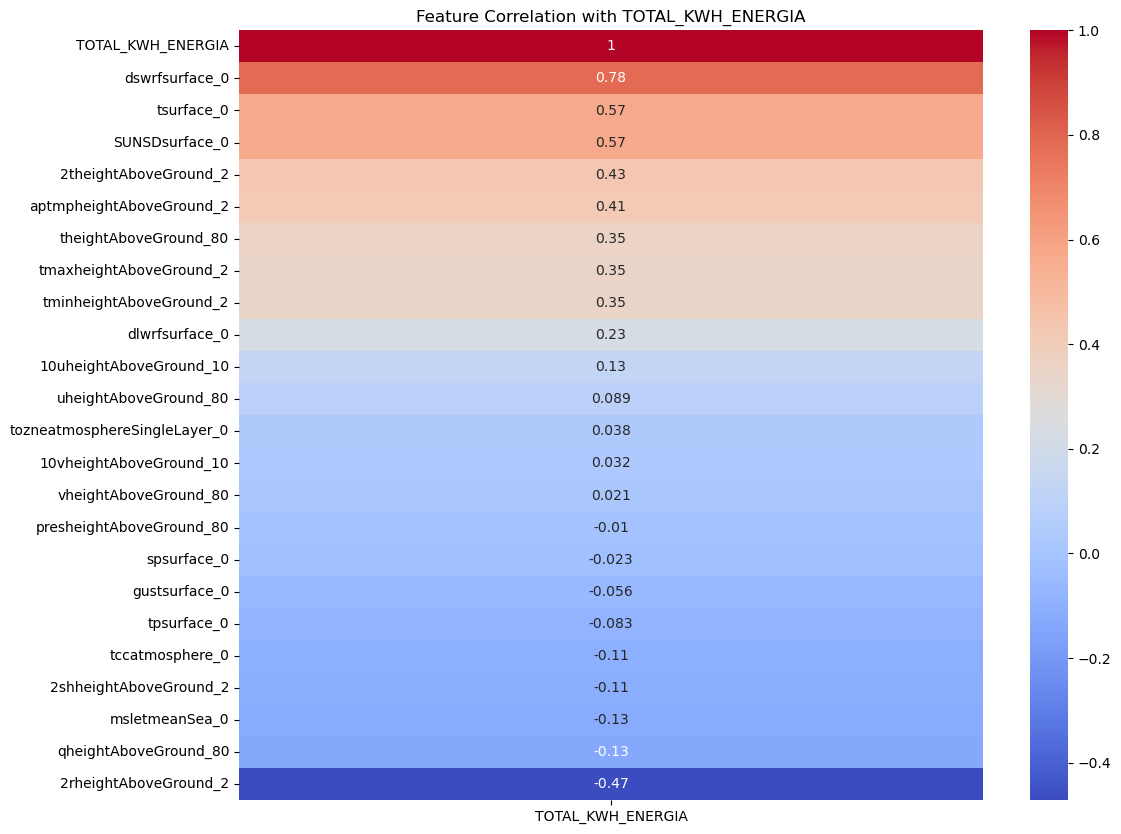

In [116]:
# VISUALIZE CORRRELATION MATRIX
corr_df = df_train.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df[['TOTAL_KWH_ENERGIA']].sort_values(by='TOTAL_KWH_ENERGIA', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation with TOTAL_KWH_ENERGIA")
plt.show()

In [117]:
# CHECK FOR STRONG CORRELATIONS
# STRONG CORRELATIONS: > 0.8
corr_pairs = corr_df.unstack()
filtered_corr = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
filtered_corr = filtered_corr.drop_duplicates()
top_corr = filtered_corr.reindex(filtered_corr.abs().sort_values(ascending=False).index)

top_corr.head(50)  
strong_corr = top_corr[top_corr.abs() > 0.8]
print(strong_corr)

presheightAboveGround_80  spsurface_0                 0.999284
2shheightAboveGround_2    qheightAboveGround_80       0.995106
10uheightAboveGround_10   uheightAboveGround_80       0.992439
10vheightAboveGround_10   vheightAboveGround_80       0.991522
2theightAboveGround_2     aptmpheightAboveGround_2    0.990912
                          theightAboveGround_80       0.983776
theightAboveGround_80     tmaxheightAboveGround_2     0.981316
aptmpheightAboveGround_2  theightAboveGround_80       0.979074
2theightAboveGround_2     tmaxheightAboveGround_2     0.975635
theightAboveGround_80     tminheightAboveGround_2     0.973996
aptmpheightAboveGround_2  tmaxheightAboveGround_2     0.968677
tmaxheightAboveGround_2   tminheightAboveGround_2     0.966682
msletmeanSea_0            spsurface_0                 0.966022
2theightAboveGround_2     tminheightAboveGround_2     0.963624
aptmpheightAboveGround_2  tminheightAboveGround_2     0.955839
msletmeanSea_0            presheightAboveGround_80    0

**NOTE** : Now we will check for **multicollinearity** in the dataframe using the variance inflation factor (VIF).

In [118]:
# CHECK FOR MULTICOLLINEARITY
def calculate_vif(df, features):

    X_vif = sm.add_constant(df[features])
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                       for i in range(X_vif.shape[1])]
    vif_data = vif_data[vif_data["feature"] != "const"]

    return vif_data.reset_index(drop=True)

In [119]:
# SELECT FEATURES FOR VIF
features = [col for col in df_train.columns if col != "TOTAL_KWH_ENERGIA" and col != "FORECAST_TIMESTAMP"]

vif_results = calculate_vif(df_train, features)
vif_results_sorted = vif_results.sort_values(by='VIF')
print(vif_results_sorted)

                         feature           VIF
19                   tpsurface_0  1.290411e+00
14               tccatmosphere_0  1.824224e+00
18  tozneatmosphereSingleLayer_0  1.919019e+00
9                  gustsurface_0  2.971823e+00
5                 SUNSDsurface_0  4.930738e+00
7                 dlwrfsurface_0  9.297362e+00
8                 dswrfsurface_0  1.161708e+01
2          2rheightAboveGround_2  2.420561e+01
16       tmaxheightAboveGround_2  4.727525e+01
20                    tsurface_0  6.065706e+01
22         vheightAboveGround_80  8.025001e+01
1        10vheightAboveGround_10  8.160494e+01
21         uheightAboveGround_80  8.704646e+01
0        10uheightAboveGround_10  8.724701e+01
17       tminheightAboveGround_2  1.026208e+02
6       aptmpheightAboveGround_2  1.292681e+02
3         2shheightAboveGround_2  1.430078e+02
12         qheightAboveGround_80  1.530301e+02
4          2theightAboveGround_2  5.036179e+02
15         theightAboveGround_80  1.314550e+03
10           

In [120]:
# PREPARE DATAFRAME FOR FEATURE ENGINEERING
# NEW DATAFRAME: DF_V1
df_V1 = df_aggregated.copy()

**NOTE** : Now we will proceed with **feature engineering** by dropping unneeded features based on the correlation check and multicollinearity check.

In [121]:
# TIME 
df_V1['hour'] = df_V1['FORECAST_TIMESTAMP'].dt.hour
df_V1['dayofweek'] = df_V1['FORECAST_TIMESTAMP'].dt.dayofweek

df_V1['hour_sin'] = np.sin(2 * np.pi * df_V1['hour'] / 24.0)
df_V1['hour_cos'] = np.cos(2 * np.pi * df_V1['hour'] / 24.0)
df_V1['dayofweek_sin'] = np.sin(2 * np.pi * df_V1['dayofweek'] / 7.0)
df_V1['dayofweek_cos'] = np.cos(2 * np.pi * df_V1['dayofweek'] / 7.0)

df_V1 = df_V1.drop(['hour', 'dayofweek'], axis=1)

# PRESSURE 
df_V1['avg_pressure'] = (df_V1['spsurface_0']+df_V1['presheightAboveGround_80']+df_V1['msletmeanSea_0']) / 3
df_V1 = df_V1.drop(['spsurface_0', 'presheightAboveGround_80', 'msletmeanSea_0'], axis=1)

# RADIATION
df_V1['total_radiation'] = df_V1['dlwrfsurface_0'] + df_V1['dswrfsurface_0']
df_V1 = df_V1.drop(['dlwrfsurface_0', 'dswrfsurface_0'], axis=1)

# HUMIDITY
df_V1['avg_humidity'] = (df_V1["2shheightAboveGround_2"] + df_V1['qheightAboveGround_80']) / 2
df_V1 = df_V1.drop(['2rheightAboveGround_2', '2shheightAboveGround_2','qheightAboveGround_80'], axis=1)

# TEMPERATURE
df_V1['avg_temp'] = (df_V1['tmaxheightAboveGround_2'] + df_V1['tminheightAboveGround_2'] + df_V1['aptmpheightAboveGround_2']+df_V1['2theightAboveGround_2']+df_V1['theightAboveGround_80']+df_V1['tsurface_0']) / 6
df_V1 = df_V1.drop(['tmaxheightAboveGround_2', 'tminheightAboveGround_2', 'aptmpheightAboveGround_2', '2theightAboveGround_2', 'theightAboveGround_80','tsurface_0'], axis=1)

# WIND
df_V1['avg_wind_u'] = (df_V1['10uheightAboveGround_10'] + df_V1['uheightAboveGround_80']) / 2
df_V1['avg_wind_v'] = (df_V1['vheightAboveGround_80'] + df_V1['10vheightAboveGround_10']) / 2
df_V1 = df_V1.drop(['10vheightAboveGround_10', '10uheightAboveGround_10','uheightAboveGround_80', 'vheightAboveGround_80'], axis=1)

# CLOUD COVER
df_V1['dlwrf_cloud_interaction'] = df_V1['total_radiation'] * (df_V1['tccatmosphere_0'] / 100)
df_V1 = df_V1.drop(['tccatmosphere_0'], axis=1)

In [122]:
# CHECK FOR OUTLIERS
features = [col for col in df_V1.columns if col not in ['FORECAST_TIMESTAMP', 'TOTAL_KWH_ENERGIA']]

q1 = df_V1[features].quantile(0.25)
q3 = df_V1[features].quantile(0.75)
IQR = q3 - q1

print("Outlier Percentages:")
outlier_percentages = {}

for f in features:
    lower_bound = q1[f] - 1.5 * IQR[f]
    upper_bound = q3[f] + 1.5 * IQR[f]
    
    num_outliers = ((df_V1[f] < lower_bound) | (df_V1[f] > upper_bound)).sum()
    outlier_percentage = round((num_outliers / len(df_V1)) * 100, 2)
    
    outlier_percentages[f] = outlier_percentage
    print(f"{f}: {outlier_percentage}% outliers")

Outlier Percentages:
SUNSDsurface_0: 0.0% outliers
gustsurface_0: 2.21% outliers
tozneatmosphereSingleLayer_0: 3.68% outliers
tpsurface_0: 20.68% outliers
hour_sin: 0.0% outliers
hour_cos: 0.0% outliers
dayofweek_sin: 0.0% outliers
dayofweek_cos: 0.0% outliers
avg_pressure: 5.78% outliers
total_radiation: 2.94% outliers
avg_humidity: 0.6% outliers
avg_temp: 0.0% outliers
avg_wind_u: 0.55% outliers
avg_wind_v: 4.53% outliers
dlwrf_cloud_interaction: 3.2% outliers


**NOTE** : Now we will handle **outliers** by dropping them while keeping in mind correlation and multicollinearity.

In [123]:
# DROP OUTLIERS
df_V1 = df_V1.drop(['tpsurface_0','tozneatmosphereSingleLayer_0' ], axis=1)

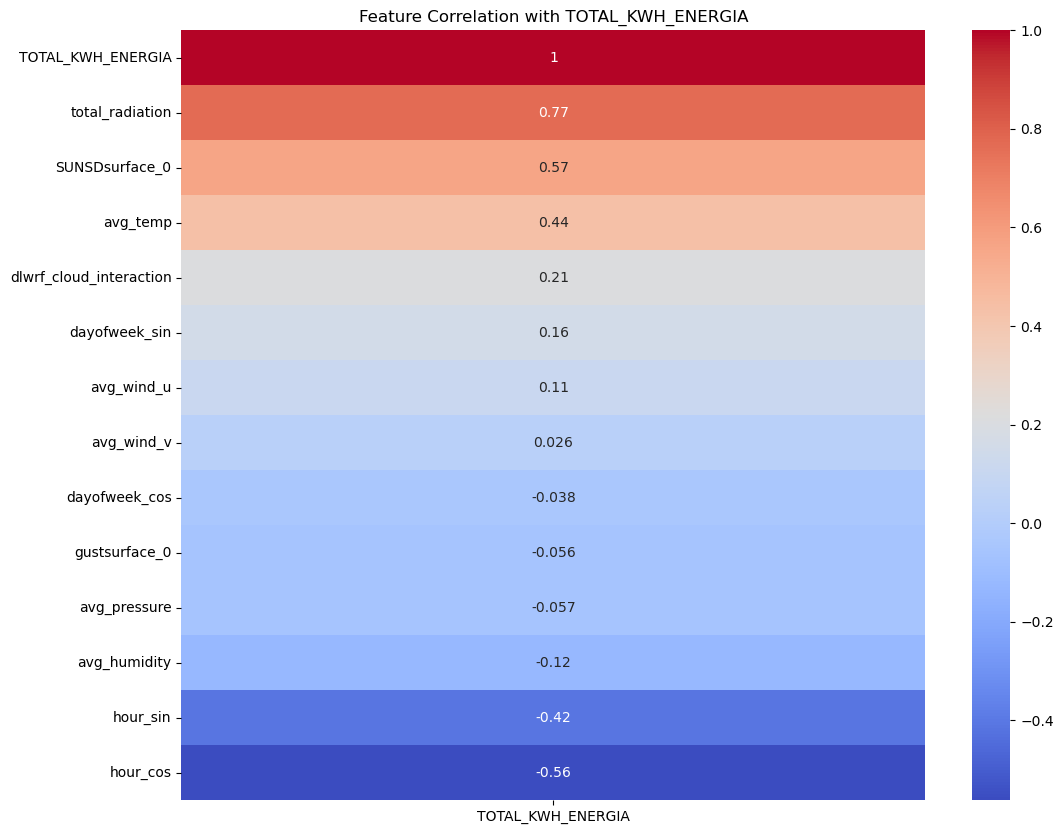

In [124]:
# CHECK FOR STRONG CORRELATIONS
corr_df = df_V1.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df[['TOTAL_KWH_ENERGIA']].sort_values(by='TOTAL_KWH_ENERGIA', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation with TOTAL_KWH_ENERGIA")
plt.show()

In [125]:
# SELECT FEATURES FOR VIF
features = [col for col in df_V1.columns if col != "TOTAL_KWH_ENERGIA" and col != "FORECAST_TIMESTAMP"]

vif_results = calculate_vif(df_V1, features)
vif_results_sorted = vif_results.sort_values(by='VIF')
print(vif_results_sorted)

                    feature       VIF
4             dayofweek_sin  1.007856
5             dayofweek_cos  1.015558
12  dlwrf_cloud_interaction  1.366719
11               avg_wind_v  1.423925
8              avg_humidity  1.529255
10               avg_wind_u  1.701593
2                  hour_sin  1.755252
6              avg_pressure  1.801858
1             gustsurface_0  1.935593
0            SUNSDsurface_0  2.282011
9                  avg_temp  2.918780
3                  hour_cos  2.999187
7           total_radiation  4.607424


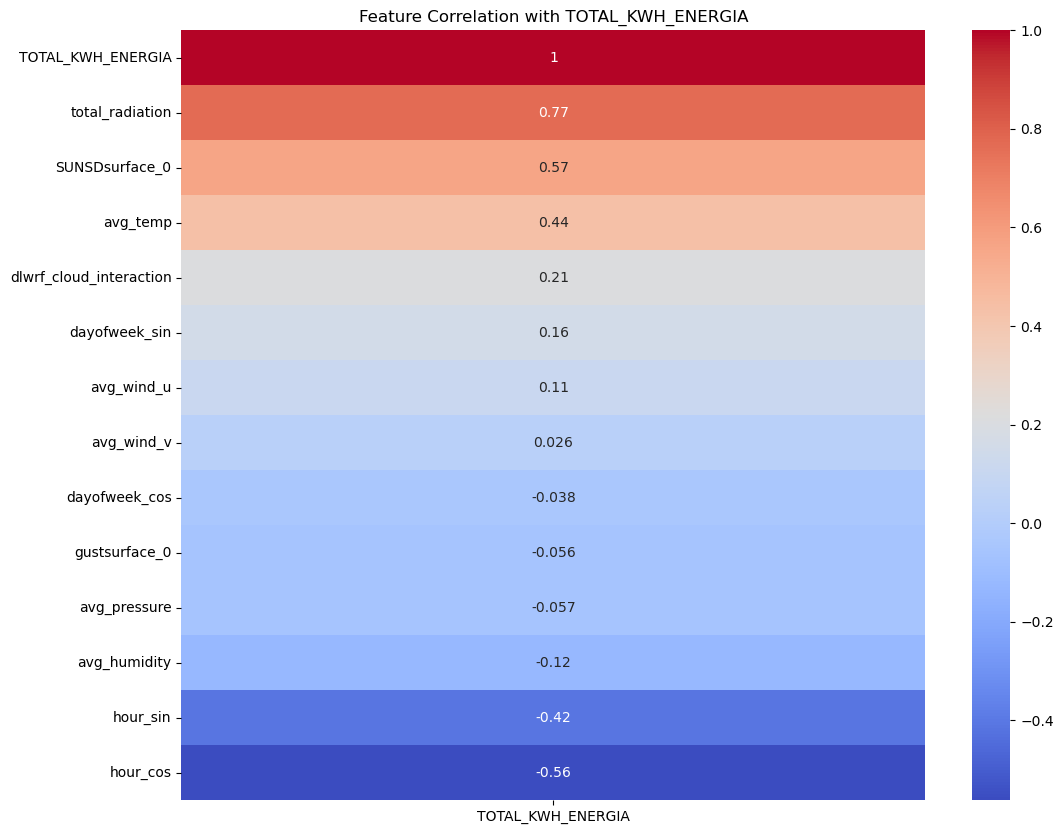

In [126]:
# VISUALIZE CORRRELATION MATRIX
corr_df = df_V1.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df[['TOTAL_KWH_ENERGIA']].sort_values(by='TOTAL_KWH_ENERGIA', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation with TOTAL_KWH_ENERGIA")
plt.show()

In [127]:
# DROP UNNEEDED COLUMNS
df_V1 = df_V1.drop(['avg_wind_u','dayofweek_cos', 'gustsurface_0'], axis=1)

In [128]:
# PREPARE DATAFRAME FOR TRAINING
# NEW DATAFRAME: DF_V2
df_V2 = df_V1.copy()
df_V2 = df_V2[df_V2["TOTAL_KWH_ENERGIA"].notnull()] 

In [129]:
# FEATURES: 8,544 NON-NULLS
# TARGET: 8,544 NON-NULLS
df_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8544 entries, 1 to 9692
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   FORECAST_TIMESTAMP       8544 non-null   datetime64[ns]
 1   SUNSDsurface_0           8544 non-null   float64       
 2   TOTAL_KWH_ENERGIA        8544 non-null   float64       
 3   hour_sin                 8544 non-null   float64       
 4   hour_cos                 8544 non-null   float64       
 5   dayofweek_sin            8544 non-null   float64       
 6   avg_pressure             8544 non-null   float64       
 7   total_radiation          8544 non-null   float64       
 8   avg_humidity             8544 non-null   float64       
 9   avg_temp                 8544 non-null   float64       
 10  avg_wind_v               8544 non-null   float64       
 11  dlwrf_cloud_interaction  8544 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memor

**NOTE** : Now we will build the **ML models** that will predict solar generation.

In [130]:
# SPLIT TRAIN-TEST
features = [col for col in df_V2.columns if col not in ['TOTAL_KWH_ENERGIA', 'FORECAST_TIMESTAMP']]

X = df_V2[features]
y = df_V2['TOTAL_KWH_ENERGIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [131]:
# BUILD FIRST MODEL
# MODEL 1: XGBOOST
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# CHECK MAE
y_pred_valid = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_valid)
print(f"Validation MAE: {mae:.4f}")

Validation MAE: 6.1140


In [132]:
# DO HYPERPARAMETER TUNING FOR XGBOOST
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  
    scoring='neg_mean_absolute_error',
    cv=3,  
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_

y_pred_best = best_xgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Best Validation MAE: {mae_best:.4f}")
print("Best Parameters:", random_search.best_params_)

Best Validation MAE: 5.7919
Best Parameters: {'colsample_bytree': 0.9917115704474215, 'learning_rate': 0.08976488848891061, 'max_depth': 9, 'n_estimators': 339, 'subsample': 0.8991725624922755}


In [133]:
# PREPARE DATAFRAME FOR MODEL
# NEW DATAFRAME: DF_RF
df_rf = df_V1.copy()
df_rf = df_rf[df_rf["TOTAL_KWH_ENERGIA"].notnull()] 

In [134]:
# BUILD SECOND MODEL
# MODEL 2: RANDOM FOREST
features = [col for col in df_rf.columns if col not in ['TOTAL_KWH_ENERGIA', 'FORECAST_TIMESTAMP']]

X = df_rf[features]
y = df_rf['TOTAL_KWH_ENERGIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [135]:
# CHECK MAE
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_preds)
print("Random Forest MAE:", mae_rf)

Random Forest MAE: 8.09925410394131


In [136]:
# DO HYPERPARAMETER TUNING FOR RANDOM FOREST
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [137]:
# PERFORM GRID SEARCH
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [138]:
# CHECK MAE
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (CV):", -grid_search.best_score_)

best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, rf_preds)
print("Tuned Random Forest MAE:", mae)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE (CV): 6.934242040850996
Tuned Random Forest MAE: 6.397518607372958


In [139]:
# PREPARE DATAFRAME FOR MODEL
# NEW DATAFRAME: DF_V5
df_V5 = df_V1.copy()
df_V5 = df_V5[df_V5["TOTAL_KWH_ENERGIA"].notnull()] 

In [140]:
# BUILD THIRD MODEL
# MODEL 3: LIGHT G BOOST
features = [col for col in df_V5.columns if col not in ['TOTAL_KWH_ENERGIA', 'FORECAST_TIMESTAMP']]

X = df_V5[features]
y = df_V5['TOTAL_KWH_ENERGIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [141]:
# CHECK MAE
lgb_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, lgb_preds)
print("LightGBM MAE:", mae_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 6835, number of used features: 10
[LightGBM] [Info] Start training from score 25.599871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [142]:
# DO HYPERPARAMETER TUNING FOR LIGHT G BOOST
param_dist = {
    'n_estimators': sp_randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': sp_randint(3, 10),
    'num_leaves': sp_randint(20, 100),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

best_lgb = random_search.best_estimator_

# CHECK MAE
y_pred_best = best_lgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Best Validation MAE: {mae_best:.4f}")
print("Best Parameters:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Total Bi

**NOTE** : Now we will build the **final ML model** by combining previously built models above.

In [143]:
# PREPARE DATAFRAME FOR FINAL MODEL
# NEW DATAFRAME: DF_V6
df_V6 = df_V1.copy()
df_V6 = df_V6[df_V6["TOTAL_KWH_ENERGIA"].notnull()] 

In [144]:
# BUILD FINAL MODEL
# MODEL: STACKED REGRESSOR
features = [col for col in df_V6.columns if col not in ['TOTAL_KWH_ENERGIA', 'FORECAST_TIMESTAMP']]

X = df_V6[features]
y = df_V6['TOTAL_KWH_ENERGIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [145]:
# SET UP BASE MODELS
base_models = [
    ('xgb', best_xgb),
    ('lgb', best_lgb),
    ('rf', best_rf),
]

In [146]:
# SET UP STACKED MODEL
meta_model = Ridge(alpha=1.0)

In [147]:
# BUILD STACKED MODEL
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False  # if True, meta-model gets both original features + base preds
)

stack_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 6835, number of used features: 10
[LightGBM] [Info] Start training from score 25.599871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9917115704474215,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrain...
                                            n_estimators=339, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.9238004184558861,
                                             learning_rate=0.11459979618751881,
                                             max_depth=9, n_estimators=101,
                                             num_leaves=52, random_state=42,
                                             subsample=0.759028808435009)),
                              ('rf',
                               RandomForestRegressor(max_features='sqrt',
                                                     n_estimators=200,
                                                     random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

In [148]:
# CHECK MAE
preds = stack_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("Stacked Model MAE:", mae)

Stacked Model MAE: 5.891457310855806


**NOTE** : Now we will use the stacked model to predict the **optimal solar generation**.

In [149]:
# FILL IN MISSING VALUES WITH TRAINED MODEL
df_stack = df_V1.copy()
df_stack = df_stack[df_stack['TOTAL_KWH_ENERGIA'].isnull()]
features = [col for col in df_stack.columns if col not in ['TOTAL_KWH_ENERGIA', 'FORECAST_TIMESTAMP']]
X_missing = df_stack[features]
X_missing_scaled = scaler.transform(X_missing)
y_missing_pred = stack_model.predict(X_missing_scaled)
df_stack.loc[X_missing.index, 'TOTAL_KWH_ENERGIA'] = y_missing_pred

In [168]:
# EXTRACT SEPTEMBER DATA
df_sept_stack = df_stack[
    (df_stack["FORECAST_TIMESTAMP"] >= "2024-09-01") &
    (df_stack["FORECAST_TIMESTAMP"] < "2024-10-01")
].copy()

df_sept_stack["FORECAST_TIMESTAMP"] = pd.to_datetime(df_sept_stack["FORECAST_TIMESTAMP"])

df_sept_stack["TOTAL_KWH_ENERGIA"] = df_sept_stack["TOTAL_KWH_ENERGIA"].clip(lower=0)

df_sept_trimmed = df_sept_stack[["FORECAST_TIMESTAMP", "TOTAL_KWH_ENERGIA"]]
df_sept_trimmed.to_csv("file1_maxsolar.csv", index=True)
df_sept_trimmed

,FORECAST_TIMESTAMP,TOTAL_KWH_ENERGIA
9709,2024-09-01 00:00:00,0.000000
9710,2024-09-01 01:00:00,0.000000
9711,2024-09-01 02:00:00,0.000000
9712,2024-09-01 03:00:00,0.000000
9713,2024-09-01 04:00:00,0.000000
...,...,...
10424,2024-09-30 19:00:00,20.562905
10425,2024-09-30 20:00:00,5.510856
10426,2024-09-30 21:00:00,0.227675
10427,2024-09-30 22:00:00,0.000000


## OBJECTIVE 2 : OPTIMIZATION OF BATTERY USAGE

In [151]:
# LOAD CONSUMO DATA
df_con_solar = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/Consumo_fotovoltaica.csv")
df_con = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/Consumo.csv")
df_con_sept = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/Consumo_sept (1).csv")

In [152]:
# MERGE THE DATA
df_combined = pd.concat([df_con, df_con_sept], ignore_index=True)
df_combined = df_combined.rename(columns={"FECHA": "FORECAST_TIMESTAMP"})
df_combined["FORECAST_TIMESTAMP"] = pd.to_datetime(df_combined["FORECAST_TIMESTAMP"]) 
df_con_solar = df_con_solar.rename(columns={"FECHA": "FORECAST_TIMESTAMP"})
df_con_solar["FORECAST_TIMESTAMP"] = pd.to_datetime(df_con_solar["FORECAST_TIMESTAMP"]) 
df_con_solar["TOTAL_KWH_ENERGIA"] = df_con_solar["TOTAL_KWH_ENERGIA"].clip(lower=0)
df_con_solar["FORECAST_TIMESTAMP"] = df_con_solar["FORECAST_TIMESTAMP"].dt.tz_localize(None)

In [153]:
# MERGE THE DATA
# FINAL MERGED DATAFRAME: DF_SEPT_MERGED
df_sept_merged = pd.merge(df_sept_trimmed, df_con_solar, on="FORECAST_TIMESTAMP", how="inner")
df_sept_merged.set_index("FORECAST_TIMESTAMP", inplace=True)
df_sept_merged.rename(columns={
    "TOTAL_KWH_ENERGIA_x": "SOLAR_KWH_GENERATED",
    "TOTAL_KWH_ENERGIA_y": "SOLAR_KWH_CONSUMED"
}, inplace=True)
df_sept_merged["EXCESS_ENERGY"] = (df_sept_merged["SOLAR_KWH_GENERATED"] - df_sept_merged["SOLAR_KWH_CONSUMED"]).clip(lower=0)
df_sept_merged.head(10)

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY
FORECAST_TIMESTAMP,,,
2024-09-01 00:00:00,0.000000,0.00,0.000000
2024-09-01 01:00:00,0.000000,0.00,0.000000
2024-09-01 02:00:00,0.000000,0.00,0.000000
2024-09-01 03:00:00,0.000000,0.00,0.000000
2024-09-01 04:00:00,0.000000,0.00,0.000000
2024-09-01 05:00:00,0.000000,0.00,0.000000
2024-09-01 06:00:00,0.000000,0.00,0.000000
2024-09-01 07:00:00,0.197475,0.00,0.197475
2024-09-01 08:00:00,0.636023,0.00,0.636023


In [154]:
# CREATE TIMESTAMP
df_sept_master = pd.merge(df_sept_merged, df_combined, on="FORECAST_TIMESTAMP", how="inner")
df_sept_master.set_index("FORECAST_TIMESTAMP", inplace=True)
df_sept_master.head()
df_sept_master.rename(columns={
    "TOTAL_KWH_ENERGIA": "GRID_CONSUMO"
}, inplace=True)
df_sept_master.head()

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,GRID_CONSUMO
FORECAST_TIMESTAMP,,,,
2024-09-01 00:00:00,0.0,0.0,0.0,110.855888
2024-09-01 01:00:00,0.0,0.0,0.0,107.341202
2024-09-01 02:00:00,0.0,0.0,0.0,105.550308
2024-09-01 03:00:00,0.0,0.0,0.0,106.840103
2024-09-01 04:00:00,0.0,0.0,0.0,105.879791


In [155]:
# VALUES: 710 NON-NULLS
df_sept_master.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2024-09-01 00:00:00 to 2024-09-30 23:00:00
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SOLAR_KWH_GENERATED  720 non-null    float64
 1   SOLAR_KWH_CONSUMED   720 non-null    float64
 2   EXCESS_ENERGY        720 non-null    float64
 3   GRID_CONSUMO         710 non-null    float64
dtypes: float64(4)
memory usage: 28.1 KB


In [156]:
# CHECK FOR NULLS
null_rows = df_sept_master[df_sept_master['GRID_CONSUMO'].isnull()]
null_rows

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,GRID_CONSUMO
FORECAST_TIMESTAMP,,,,
2024-09-03 23:00:00,0.000000,0.00,0.000000,NaN
2024-09-04 00:00:00,0.000000,0.00,0.000000,NaN
2024-09-08 16:00:00,66.236413,119.94,0.000000,NaN
2024-09-08 17:00:00,23.141483,111.71,0.000000,NaN
2024-09-27 13:00:00,138.347230,135.54,2.807230,NaN
2024-09-28 10:00:00,37.548271,0.00,37.548271,NaN
2024-09-28 11:00:00,60.837854,0.00,60.837854,NaN
2024-09-28 12:00:00,41.708948,0.00,41.708948,NaN
2024-09-28 13:00:00,60.029314,0.00,60.029314,NaN


In [157]:
# FILL IN NULLS USING PREVIOUS WEEK'S DATA
for ts in df_sept_master[df_sept_master['GRID_CONSUMO'].isnull()].index:
    week_before = ts - pd.Timedelta(weeks=1)
    if week_before in df_sept_master.index:
        df_sept_master.at[ts, 'GRID_CONSUMO'] = df_sept_master.at[week_before, 'GRID_CONSUMO']

In [158]:
# CHECK FOR NULLS
null_rows = df_sept_master[df_sept_master['GRID_CONSUMO'].isnull()]
null_rows

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,GRID_CONSUMO
FORECAST_TIMESTAMP,,,,
2024-09-03 23:00:00,0.0,0.0,0.0,NaN
2024-09-04 00:00:00,0.0,0.0,0.0,NaN


In [159]:
# FILL IN NULLS USING NEXT WEEK'S DATA
for ts in df_sept_master[df_sept_master['GRID_CONSUMO'].isnull()].index:
    week_after = ts + pd.Timedelta(weeks=1)
    if week_after in df_sept_master.index:
        df_sept_master.at[ts, 'GRID_CONSUMO'] = df_sept_master.at[week_after, 'GRID_CONSUMO']


In [160]:
# VALUES : 720 NON-NULLS
df_sept_master.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2024-09-01 00:00:00 to 2024-09-30 23:00:00
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SOLAR_KWH_GENERATED  720 non-null    float64
 1   SOLAR_KWH_CONSUMED   720 non-null    float64
 2   EXCESS_ENERGY        720 non-null    float64
 3   GRID_CONSUMO         720 non-null    float64
dtypes: float64(4)
memory usage: 44.3 KB


In [161]:
# SET UP THEORETICAL BATTERY
def simulate_battery(df):
    df["BATTERY_CHARGED"] = 0.0
    df["BATTERY_DISCHARGED"] = 0.0
    df["DATE"] = df.index.date

    for day in df["DATE"].unique():
        day_df = df[df["DATE"] == day]
        available_charge = 0.0
        charge_log = {}
        last_charge_idx = None

        # STEP 1: CHARGE DUSING EARLIEST EXCESS_ENERGY HOUR
        for idx, row in day_df.iterrows():
            if available_charge >= 100:
                break
            charge_now = min(100 - available_charge, row["EXCESS_ENERGY"])
            if charge_now > 0:
                charge_log[idx] = charge_now
                available_charge += charge_now
                last_charge_idx = idx  # TO TRACK THE LAST CHARGING HOUR

        # INPUT BATTERY_CHARGED TO DATAFRAME
        for idx, charge_now in charge_log.items():
            df.at[idx, "BATTERY_CHARGED"] = charge_now

        # STEP 2: DISCHARGE ONCE AT THE HOUR AFTER CHARGING AND TIMED AT THE MAX GRID_CONSUMO
        if available_charge > 0 and last_charge_idx is not None:
            post_charge_df = day_df[day_df.index > last_charge_idx] # TO FILTER ONLY THE HOURS AFTER THE LAST CHARGING HOUR
            if not post_charge_df.empty:
                discharge_idx = post_charge_df["GRID_CONSUMO"].idxmax()
                df.at[discharge_idx, "BATTERY_DISCHARGED"] = min(available_charge, 100)

    return df.drop(columns="DATE")

df_sept_master = simulate_battery(df_sept_master)
df_sept_master.head(30)

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,GRID_CONSUMO,BATTERY_CHARGED,BATTERY_DISCHARGED
FORECAST_TIMESTAMP,,,,,,
2024-09-01 00:00:00,0.000000,0.00,0.000000,110.855888,0.000000,0.000000
2024-09-01 01:00:00,0.000000,0.00,0.000000,107.341202,0.000000,0.000000
2024-09-01 02:00:00,0.000000,0.00,0.000000,105.550308,0.000000,0.000000
2024-09-01 03:00:00,0.000000,0.00,0.000000,106.840103,0.000000,0.000000
2024-09-01 04:00:00,0.000000,0.00,0.000000,105.879791,0.000000,0.000000
2024-09-01 05:00:00,0.000000,0.00,0.000000,106.000397,0.000000,0.000000
2024-09-01 06:00:00,0.000000,0.00,0.000000,105.497681,0.000000,0.000000
2024-09-01 07:00:00,0.197475,0.00,0.197475,101.122337,0.197475,0.000000
2024-09-01 08:00:00,0.636023,0.00,0.636023,97.691238,0.636023,0.000000


In [162]:
# CREATE DATAFRAME WITH ONLY THE REQUIRED COLUMNS
cols = df_sept_master.columns.tolist()
new_order = ['BATTERY_CHARGED', 'GRID_CONSUMO'] + [col for col in cols if col not in ['BATTERY_CHARGED', 'GRID_CONSUMO']]

df_sept_master = df_sept_master[new_order]

new_order = [
    'SOLAR_KWH_GENERATED', 
    'SOLAR_KWH_CONSUMED',
     'EXCESS_ENERGY', 
    'BATTERY_CHARGED', 
    'GRID_CONSUMO', 
    'BATTERY_DISCHARGED'
]
df_sept_master = df_sept_master[new_order]

df_sept_master.head()

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,BATTERY_CHARGED,GRID_CONSUMO,BATTERY_DISCHARGED
FORECAST_TIMESTAMP,,,,,,
2024-09-01 00:00:00,0.0,0.0,0.0,0.0,110.855888,0.0
2024-09-01 01:00:00,0.0,0.0,0.0,0.0,107.341202,0.0
2024-09-01 02:00:00,0.0,0.0,0.0,0.0,105.550308,0.0
2024-09-01 03:00:00,0.0,0.0,0.0,0.0,106.840103,0.0
2024-09-01 04:00:00,0.0,0.0,0.0,0.0,105.879791,0.0


In [163]:
# CREATE FINAL DATAFRAME
# FINAL DATAFRAME: DF_SEPT_MASTER
df_sept_master["ENERGY_LOST"] = df_sept_master["EXCESS_ENERGY"] - df_sept_master["BATTERY_CHARGED"]
df_sept_master["REDUCTION_ENERGY_CONSUMED_FROM_GRID"] = df_sept_master["GRID_CONSUMO"] - df_sept_master["BATTERY_DISCHARGED"]

In [164]:
# CALCULATE RA
df_sept_master["SOLAR_DIRECT_USE"] = df_sept_master[["SOLAR_KWH_GENERATED", "SOLAR_KWH_CONSUMED"]].min(axis=1)
total_pv = df_sept_master["SOLAR_KWH_GENERATED"].sum()
direct_use = df_sept_master["SOLAR_DIRECT_USE"].sum()
stored_use = df_sept_master["BATTERY_DISCHARGED"].sum()

Ra = ((direct_use + stored_use) / total_pv) * 100
print(f"Self-Consumption Ratio (Ra): {Ra:.4f}%")

Self-Consumption Ratio (Ra): 90.8696%


## OBJECTIVE 3 : ANALYSIS OF ENVIRONMENTAL IMPACT

In [169]:
# LOAD ES DATA
df_carbon = pd.read_csv("/Users/joyzhong/Documents/MBD/VS/DATATHON/ES_2024_hourly.csv")

# CLEAN THE DATA
df_carbon = df_carbon.rename(columns={"Datetime (UTC)": "FORECAST_TIMESTAMP"})
df_carbon["FORECAST_TIMESTAMP"] = pd.to_datetime(df_carbon["FORECAST_TIMESTAMP"]) 
df_carbon["FORECAST_TIMESTAMP"] = df_carbon["FORECAST_TIMESTAMP"].dt.tz_localize(None)
df_carbon.set_index("FORECAST_TIMESTAMP", inplace=True)
df_carbon = df_carbon["Carbon Intensity gCO₂eq/kWh (direct)"]
df_carbon = df_carbon.to_frame(name="CARBON_INTENSITY")
df_carbon

,CARBON_INTENSITY
FORECAST_TIMESTAMP,
2024-01-01 00:00:00,93.63
2024-01-01 01:00:00,93.64
2024-01-01 02:00:00,98.90
2024-01-01 03:00:00,99.33
2024-01-01 04:00:00,102.59
...,...
2024-12-31 19:00:00,174.64
2024-12-31 20:00:00,178.07
2024-12-31 21:00:00,182.38


In [173]:
# CALCULATE C02 EMITTED OPTIMIZED
df_sept_all = pd.merge(df_sept_master, df_carbon, on="FORECAST_TIMESTAMP", how="inner")
df_sept_all['CO2_EMITTED'] = df_sept_all["GRID_CONSUMO"] * df_sept_all["CARBON_INTENSITY"]
df_sept_all = df_sept_all.drop(['SOLAR_DIRECT_USE'], axis=1)
df_sept_all.head()
df_sept_all["CO2_EMITTED_OPTIMIZED"] = (df_sept_all["REDUCTION_ENERGY_CONSUMED_FROM_GRID"] * df_sept_all["CARBON_INTENSITY"])
df_sept_all["C02_AVOIDED"] = df_sept_all["CO2_EMITTED"] - df_sept_all["CO2_EMITTED_OPTIMIZED"]
df_sept_all

,SOLAR_KWH_GENERATED,SOLAR_KWH_CONSUMED,EXCESS_ENERGY,BATTERY_CHARGED,GRID_CONSUMO,BATTERY_DISCHARGED,ENERGY_LOST,REDUCTION_ENERGY_CONSUMED_FROM_GRID,CARBON_INTENSITY,CO2_EMITTED,CO2_EMITTED_OPTIMIZED,C02_AVOIDED
FORECAST_TIMESTAMP,,,,,,,,,,,,
2024-09-01 00:00:00,0.000000,0.00,0.000000,0.000000,110.855888,0.000000,0.0,110.855888,170.04,18849.935258,18849.935258,0.000000
2024-09-01 01:00:00,0.000000,0.00,0.000000,0.000000,107.341202,0.000000,0.0,107.341202,175.13,18798.664668,18798.664668,0.000000
2024-09-01 02:00:00,0.000000,0.00,0.000000,0.000000,105.550308,0.000000,0.0,105.550308,175.53,18527.245603,18527.245603,0.000000
2024-09-01 03:00:00,0.000000,0.00,0.000000,0.000000,106.840103,0.000000,0.0,106.840103,174.22,18613.682771,18613.682771,0.000000
2024-09-01 04:00:00,0.000000,0.00,0.000000,0.000000,105.879791,0.000000,0.0,105.879791,175.05,18534.257460,18534.257460,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30 19:00:00,20.562905,36.74,0.000000,0.000000,532.989990,0.000000,0.0,532.989990,164.57,87714.162693,87714.162693,0.000000
2024-09-30 20:00:00,5.510856,4.98,0.530856,0.530856,484.213684,0.000000,0.0,484.213684,156.86,75953.758485,75953.758485,0.000000
2024-09-30 21:00:00,0.227675,0.00,0.227675,0.227675,243.039886,0.000000,0.0,243.039886,144.21,35048.782029,35048.782029,0.000000


In [167]:
# CALCULATE TOTAL CO₂ AVOIDED (CO2ev)
total_co2_avoided = df_sept_all["C02_AVOIDED"].sum()
print(f"Total CO₂ Avoided (CO2ev): {total_co2_avoided:.2f} gCO₂eq")

Total CO₂ Avoided (CO2ev): 162486.11 gCO₂eq


In [178]:
#SAVE AND DOWNLOAD THE FINAL DATA
df_co2_avoided = df_sept_all["C02_AVOIDED"]
df_co2_avoided.to_csv("file2_co2.csv", index=True)